In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
import seaborn as sns
import numpy as np
import pandas as pd
import splitfolders
import os

In [2]:
dir_dummy = 'C:\FILE SEB INSTALL ULANG 7 6 2021\KULIAH\Skripsi\deep-learning\dataset'

In [3]:
splitfolders.ratio(
    dir_dummy,
    output='dataset_splitted',
    ratio=(.7, 0.1, 0.2)
)

Copying files: 0 files [00:00, ? files/s]

Copying files: 2600 files [00:07, 351.94 files/s]


In [4]:
split_train = 'dataset_splitted/train'
split_val = 'dataset_splitted/val' 
split_test = 'dataset_splitted/test'

In [5]:
from keras.preprocessing.image import ImageDataGenerator

In [6]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=25,
                    brightness_range=(0.5,1.0),
                    shear_range=0.2,
                    zoom_range=(0.8,1.0),
                    fill_mode='nearest',
                    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    split_train,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    split_val,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    split_test,
    target_size=(150,150),
    batch_size=32,
    class_mode='categorical'
)

Found 1820 images belonging to 26 classes.
Found 260 images belonging to 26 classes.
Found 520 images belonging to 26 classes.


In [8]:
image, label = train_generator.next()

In [9]:
class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

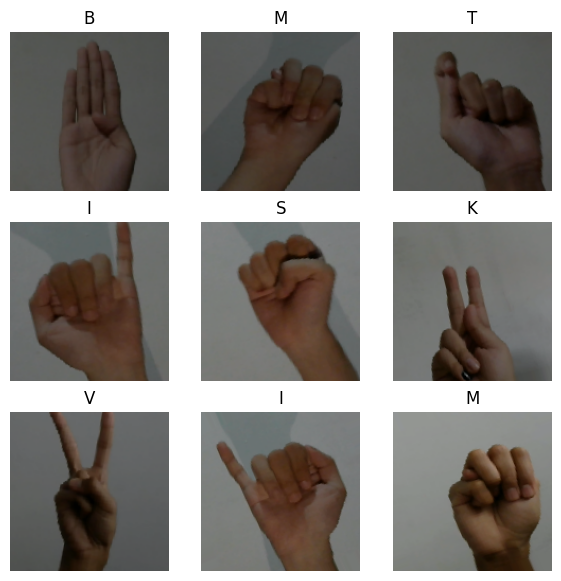

In [10]:
plt.figure(figsize=(7,7))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image[i])
  plt.title(class_name[np.argmax(label[i])])
  plt.axis("off")

In [11]:
from tensorflow import keras
from keras.callbacks import EarlyStopping
monitor_val_accuracy = EarlyStopping(monitor='val_accuracy', patience=3)

In [12]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [13]:
from tensorflow.keras.applications import InceptionV3
base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(150,150,3))

# base_model.trainable = False

In [14]:
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(tf.keras.layers.Dense(512, activation='relu'))
add_model.add(tf.keras.layers.Dense(256, activation='relu'))
add_model.add(Dropout(0.5))      
add_model.add(Dense(26, activation='softmax'))

model = add_model
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 26)                6682      
                                                        

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 26)                6682      
                                                        

In [15]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.97 and logs.get('val_accuracy')> 0.97):
      print("\nAkurasi dan validasi akurasi telah mencapai >97%! Training dihentikan!!")
      self.model.stop_training = True
history = model.fit(train_generator, 
                              epochs=20, 
                              shuffle=True, 
                              verbose=True,
                              validation_data=val_generator,
                              callbacks=[reduce_lr, myCallback()])


Epoch 1/20
57/57 [==============================] - 215s 4s/step - loss: 2.7462 - accuracy: 0.2527 - val_loss: 1.9967 - val_accuracy: 0.4654 - lr: 1.0000e-04
Epoch 2/20
57/57 [==============================] - 214s 4s/step - loss: 1.0998 - accuracy: 0.7363 - val_loss: 0.1784 - val_accuracy: 0.9231 - lr: 1.0000e-04
Epoch 3/20
57/57 [==============================] - 209s 4s/step - loss: 0.2756 - accuracy: 0.9319 - val_loss: 0.0728 - val_accuracy: 0.9731 - lr: 1.0000e-04
Epoch 4/20
57/57 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9731
Akurasi dan validasi akurasi telah mencapai >97%! Training dihentikan!!
57/57 [==============================] - 204s 4s/step - loss: 0.1170 - accuracy: 0.9731 - val_loss: 0.0050 - val_accuracy: 1.0000 - lr: 1.0000e-04


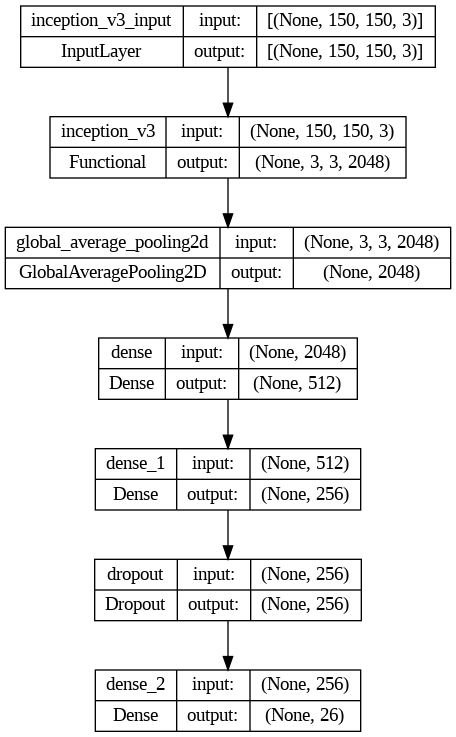

In [23]:
#plot_model(model, to_file='model_summary.png', show_shapes=True, show_layer_names=True)

In [30]:
model.save_weights("model_weights.h5")

In [16]:
model.load_weights("model_weights.h5")

In [17]:
model.save("model_weighted.h5")

In [18]:
model.save('mymodel.keras')

In [18]:
test_evaluate = model.evaluate(test_generator)

print(f'Test loss     : {test_evaluate[0]}')
print(f'Test accuracy : {round(test_evaluate[1],2)}')

17/17 [==============================] - 13s 620ms/step - loss: 0.0148 - accuracy: 0.9942
Test loss     : 0.014832928776741028
Test accuracy : 0.99


In [2]:
# model = tf.keras.models.load_model('mymodel.keras')
model = tf.keras.models.load_model('Model.h5')

In [19]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'bD-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'yo-',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

NameError: name 'history' is not defined

<Figure size 1000x1000 with 0 Axes>

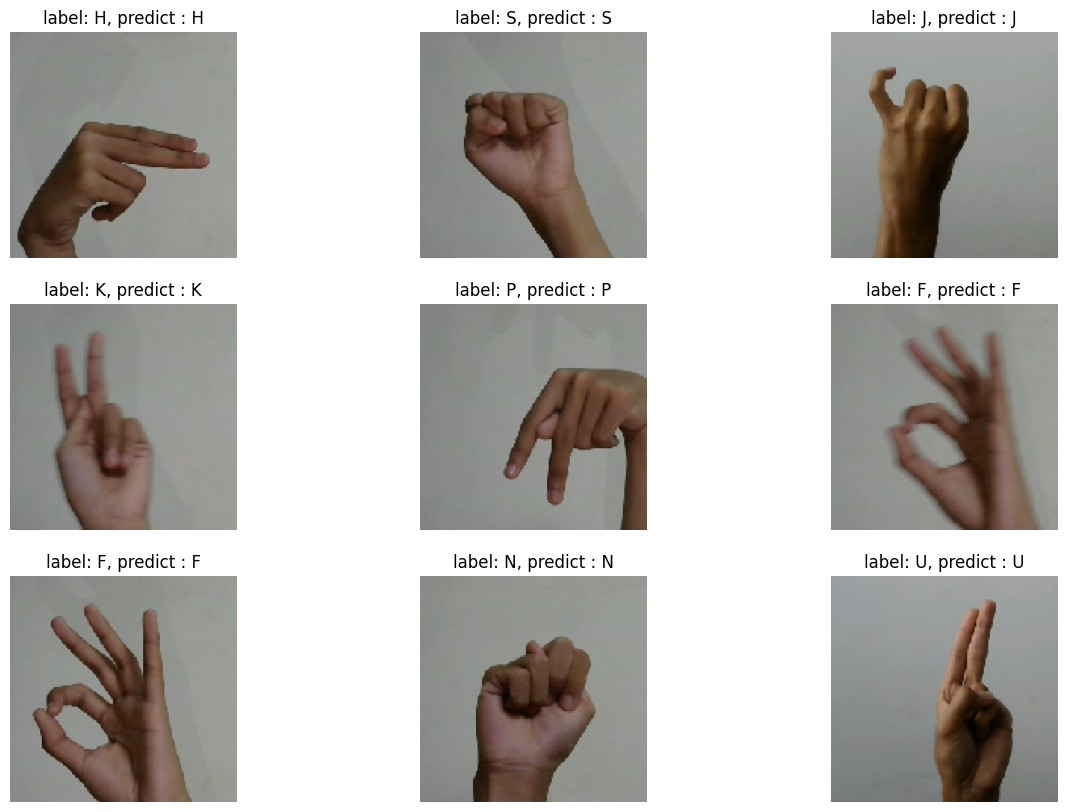

In [20]:
image ,label = next(iter(test_generator)) #mengambil 1 batch data

plt.figure(figsize=(15,10))
for i in range(9) :
    TrueLabel = class_name[np.argmax(label[i])] #mengambil label sesuai dengan index
    plt.subplot(3,3,i+1) #membuat 3 baris 3 kolom
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0)) #mengambil prediksi
    plt.imshow(tf.squeeze(image[i])) #squeeze untuk menghilangkan dimensi 1
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}') #menampilkan label dan prediksi

In [30]:
model.save('models.h5')
model.save('mymodels.keras')

In [21]:
from sklearn.metrics import confusion_matrix
import matplotlib

In [22]:
y_test = [] #label test
y_pred = [] # prediksi

for i in range(len(test_generator)) :  #mengambil semua data test
    x,y = test_generator.next() #mengambil 1 batch data
    for j in range(len(y)) : #mengambil semua label
        y_test.append(class_name[tf.argmax(y[j])]) #mengambil label sesuai dengan index
        y_pred.append(class_name[np.argmax(model.predict(x[j][None,...],verbose=0))]) #mengambil prediksi

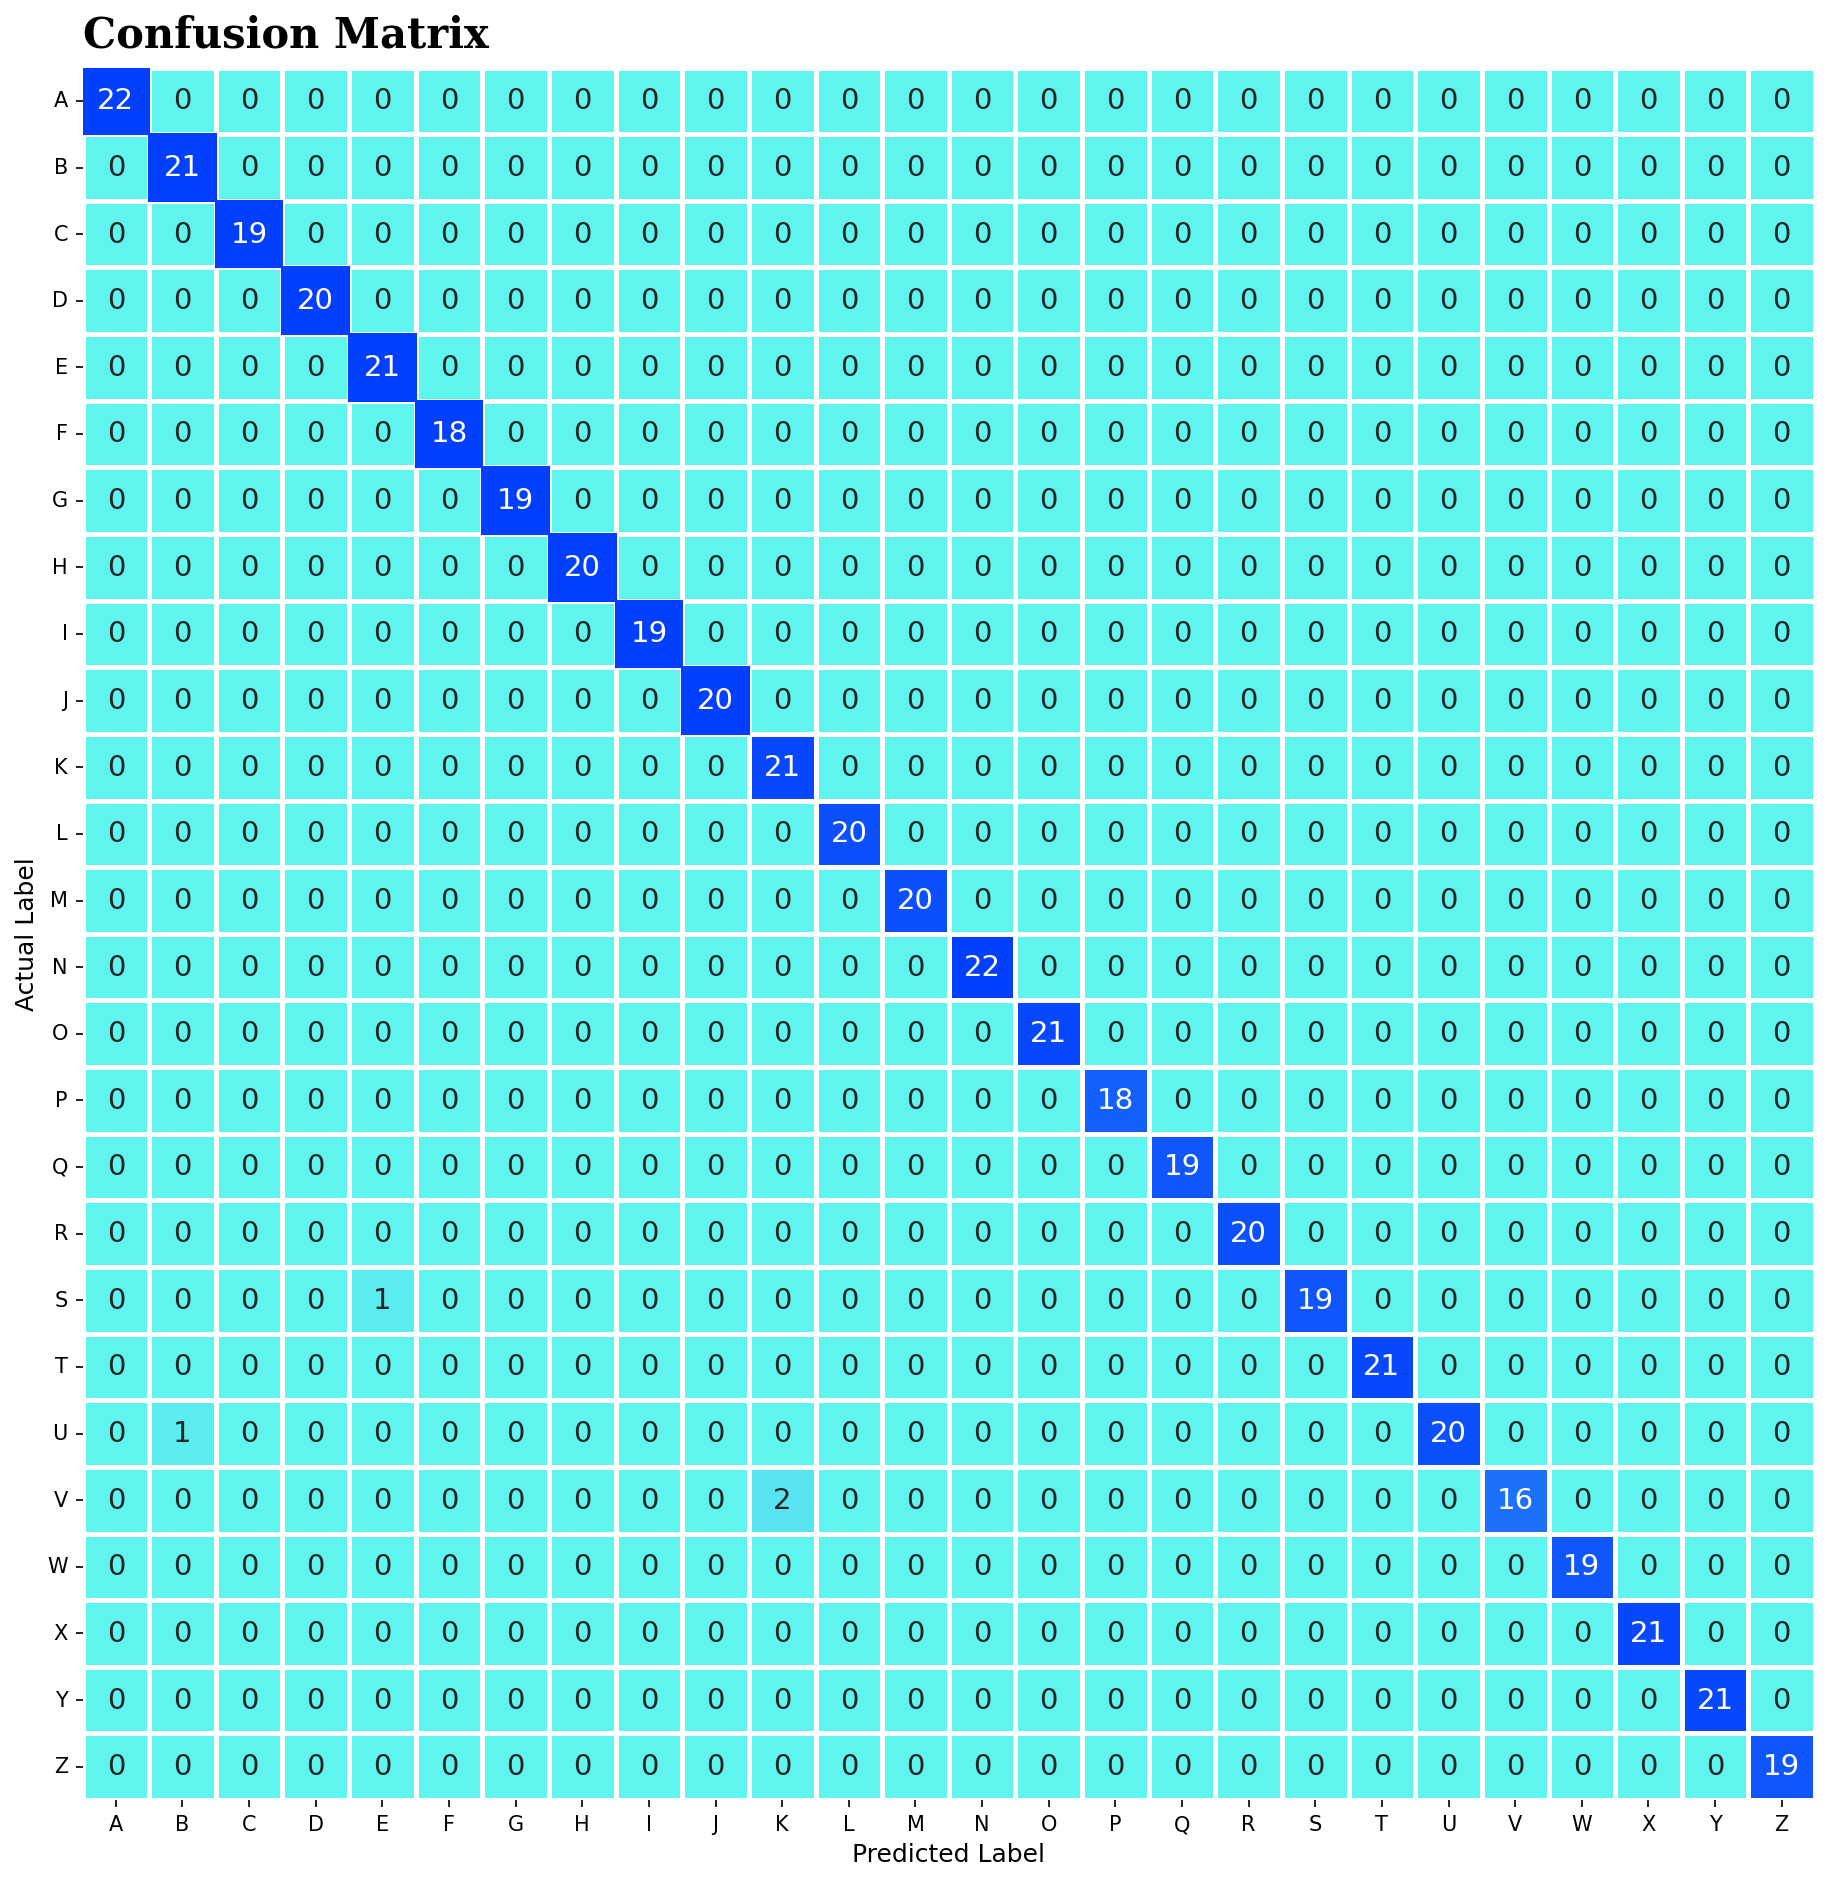

In [23]:
#Confusion Matrix
fig, ax = plt.subplots(figsize=(20, 15),dpi=150)
cm = confusion_matrix(y_test, y_pred) #membuat confusion matrix

colors = ["#5FF4EE","#033FFF"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


ax.text(0,-0.3,'Confusion Matrix ',fontfamily='serif',fontsize=20,fontweight='bold') # judul
sns.heatmap(ax=ax, data=cm,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,linewidth=1.5, annot=True,cmap=colormap, 
            annot_kws={"fontsize":14},fmt='') #membuat heatmap
ax.set_xticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
ax.set_yticklabels(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'])
plt.yticks(rotation=0)

ax.set_ylabel("Actual Label",fontsize=12)
ax.set_xlabel("Predicted Label",fontsize=12)

from matplotlib.patches import Rectangle #membuat kotak
for i in range(0,10): #
    ax.add_patch(Rectangle((i, i), 1, 1, fill=True,color="#033FFF"))

plt.show()

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

In [25]:
precission = precision_score(y_test, y_pred, pos_label='positive', average='micro') #menghitung presisi
recall = recall_score(y_test, y_pred, pos_label='positive', average='micro') #menghitung recall
f1 = f1_score(y_test, y_pred, pos_label='positive', average='micro')
accuracy = accuracy_score(y_test, y_pred)

c:\Users\nizar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\nizar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\Users\nizar\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1386: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


In [26]:
df_classification = pd.DataFrame(
    {
        "Accuracy"  : [accuracy],
        "Precision" : [precission],
        "Recall"    : [recall],
        "f1_score"  : [f1]
    },
    index = ["Model"]
)

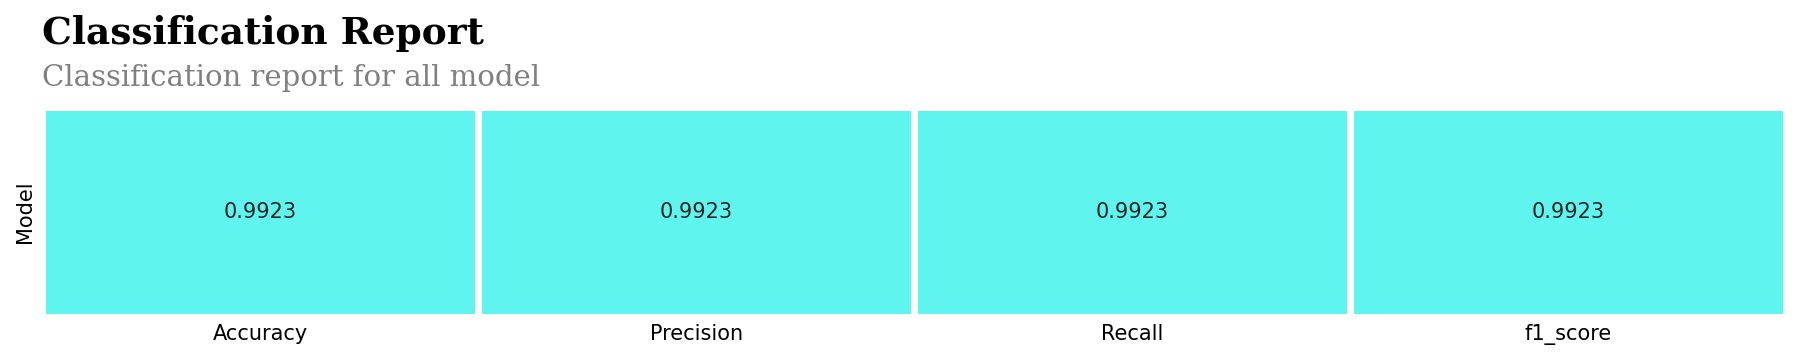

In [27]:
fig = plt.figure(figsize=(15,10), dpi=150)
gs = fig.add_gridspec(4, 4) #membuat grid
gs.update(wspace=0.1, hspace=0.5) #mengatur jarak antar grid
ax0 = fig.add_subplot(gs[0, :]) #membuat subplot

colors = ["#5FF4EE","#4A9FF5"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(df_classification, cmap=colormap,annot=True,fmt=".4f", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-0.30,'Classification Report',fontfamily='serif',fontsize=18,fontweight='bold') #judul
ax0.text(0,-0.10,'Classification report for all model',fontfamily='serif',fontsize=14,fontweight='light',color='gray')#subjudul


rect = ax0.add_patch(Rectangle((0, 1), 4, 1, fill=True,color="#FF8B13",lw=0,alpha=0.8))

plt.show()

In [28]:
print(classification_report(y_test, y_pred, target_names=class_name, digits=3))

              precision    recall  f1-score   support

           A      1.000     1.000     1.000        22
           B      0.955     1.000     0.977        21
           C      1.000     1.000     1.000        19
           D      1.000     1.000     1.000        20
           E      0.955     1.000     0.977        21
           F      1.000     1.000     1.000        18
           G      1.000     1.000     1.000        19
           H      1.000     1.000     1.000        20
           I      1.000     1.000     1.000        19
           J      1.000     1.000     1.000        20
           K      0.913     1.000     0.955        21
           L      1.000     1.000     1.000        20
           M      1.000     1.000     1.000        20
           N      1.000     1.000     1.000        22
           O      1.000     1.000     1.000        21
           P      1.000     1.000     1.000        18
           Q      1.000     1.000     1.000        19
           R      1.000    

In [ ]:
image ,label = next(iter(test_generator)) #mengambil 1 batch data

plt.figure(figsize=(15,10))
for i in range(9) :
    TrueLabel = class_name[np.argmax(label[i])] #mengambil label sesuai dengan index
    plt.subplot(3,3,i+1) #membuat 3 baris 3 kolom
    plt.axis('off')
    y_pred = np.argmax(model.predict(image[i][None,...],verbose=0)) #mengambil prediksi
    plt.imshow(tf.squeeze(image[i])) #squeeze untuk menghilangkan dimensi 1
    plt.title(f'label: {TrueLabel}, predict : {class_name[y_pred]}') #menampilkan label dan prediksi

In [2]:
# from google.colab import files
from tkinter import Tk
from tkinter.filedialog import askopenfilename
from keras.preprocessing import image
import matplotlib.image as mpimg
import numpy as np

In [4]:
model = tf.keras.models.load_model('models.h5')

In [ ]:
import random

test_dir = 'C:\FILE SEB INSTALL ULANG 7 6 2021/KULIAH/Skripsi/deep-learning/dataset_splitted/test'
df = pd.DataFrame(columns=['File Name', 'Actual', 'Predicted'])
#sample = random.randint(0, 20)
data = []
for label in os.listdir(test_dir):
    for i in range(3):
        img_name = random.choice(os.listdir(os.path.join(test_dir, label)))
        img_path = os.path.join(test_dir, label, img_name)
        img = tf.keras.utils.load_img(img_path, target_size=(150, 150))
        x = tf.keras.preprocessing.image.img_to_array(img)/255
        x = np.expand_dims(x, axis=0)
        image = np.vstack([x])
        result = model.predict(image)
        class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
        print(f'Actual: {label}, Predicted: {class_name[np.argmax(result)]}')
        # insert to df beside append
        data.append([img_name, label, class_name[np.argmax(result)]])

result_df = pd.DataFrame(data, columns=['Image', 'Actual', 'Predicted'])

In [33]:
result_df.to_csv('actual_vs_predicted.csv', index=False)

1/1 [==============================] - 2s 2s/step
R


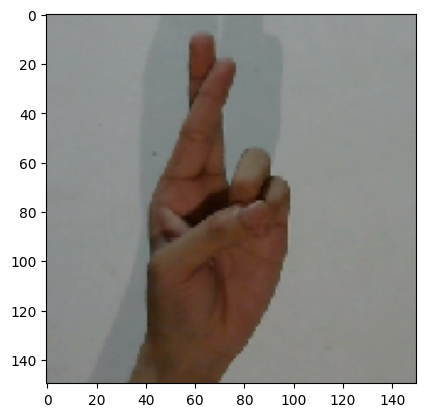

In [5]:
gambar = 'C:\FILE SEB INSTALL ULANG 7 6 2021/KULIAH/Skripsi/deep-learning/dataset_splitted/val/R/hand_343.png'
img = tf.keras.utils.load_img(gambar, target_size=(150, 150))
imgplot = plt.imshow(img)
x = tf.keras.preprocessing.image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)


image = np.vstack([x])
classes = model.predict(image, batch_size=32)

class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
print(class_name[np.argmax(classes)])